In [438]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import xgboost as xgb
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import imageio
import os
import datetime
from statsmodels.graphics.tsaplots import plot_acf
# Stats to get trend
from statsmodels.tsa.seasonal import seasonal_decompose
random.seed(42)

In [442]:
path = r"C:/Users/TurnerJosh/Desktop/SensitiveData/GoodSalesData1.xlsx"
df = pd.read_excel(path)

In [443]:
df.shape
2017-01-18 2381 

(8639, 10)

In [447]:
df['Invoice Date'].max(),df['Invoice Date'].min()

(Timestamp('2023-07-27 00:00:00'), Timestamp('2017-01-18 00:00:00'))

In [446]:
df['Invoice Date'].max() - df['Invoice Date'].min()

Timedelta('2381 days 00:00:00')

In [440]:
df = df[['Charge Amount','Invoice Date']].loc[df['Charge Amount'] != 0]
# Rename date series 'ds' and time series 'ts'
DF = df.rename(columns = {'Invoice Date': 'ds', 'Charge Amount': 'ts'})
DF.sort_values('ds',inplace=True)
DF.set_index('ds',inplace=True)


In [441]:
DF.shape

(4618, 1)

# Dealing with Outliers

In [423]:
DF = DF[(DF['ts'] < DF['ts'].mean() + 3*DF['ts'].std()) & (DF['ts'] > DF['ts'].mean() - 3*DF['ts'].std())]


# Normalize the data

In [410]:
# Normalize the data
# scaler = MinMaxScaler(feature_range=(1, 2))
# DF['ts'] = scaler.fit_transform(DF[['ts']])
# Inverse transform the predictions to put in terms of sales (no log)
# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_test_pred = scaler.inverse_transform(y_test_pred)

# Log function for skew

<Axes: xlabel='ds'>

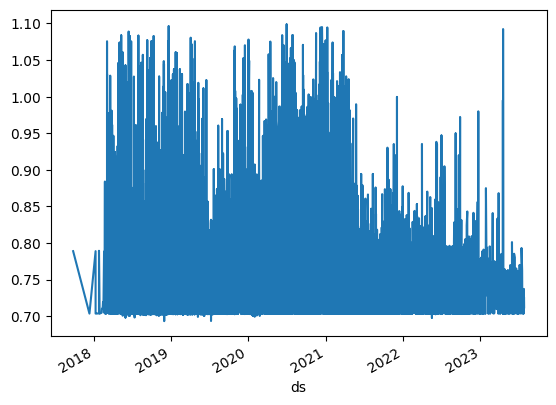

In [411]:
# Copy dataframe add log if necessary
# DF['ts'] = np.log1p(DF['ts'])
# DF = DF.copy()
# DF.ts.plot()

# Trend Analysis

In [412]:
DF.isna().sum()

ts    0
dtype: int64

# Split for model training and test predictions

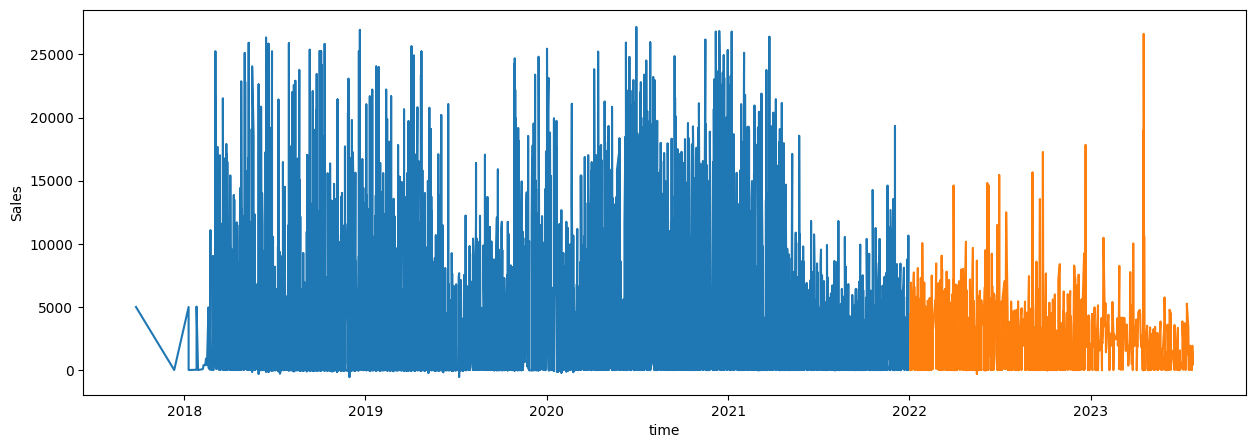

In [424]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()
train, test = split_data(DF, '01-Jan-2022')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Sales')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [458]:
train['date'] = train.index
# train['date'].dt.hour
# train.index

In [455]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    first = str(df.first('1D').index.date[0])
    last = str(df.last('1D').index.date[0])
    cal = USFederalHolidayCalendar()
    hol = cal.holidays(start=first, end=last)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].dt.weekofyear
    df['isholiday'] = np.where(
        df.index.to_period('D').astype('datetime64[ns]').isin(hol),
       1, 0
       )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','isholiday']]
    return X

In [456]:
X_train, y_train = create_features(train), train['ts']
X_test, y_test   = create_features(test), test['ts']

X_train.shape, y_train.shape

((3743, 8), (3743,))

In [426]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train
X_test_pred = reg.predict(X_test)

c:\Users\TurnerJosh\Desktop\TestProj\Test\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

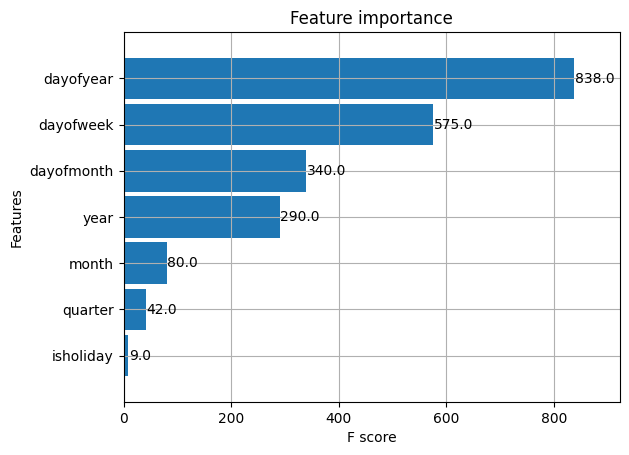

In [427]:
xgb.plot_importance(reg, height=0.9)

In [428]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('Sales')
    plt.plot(base_data.index,base_data, label='data',alpha = 0.5)
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

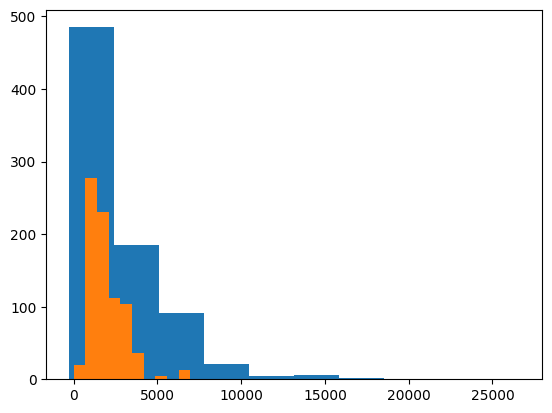

<Axes: >

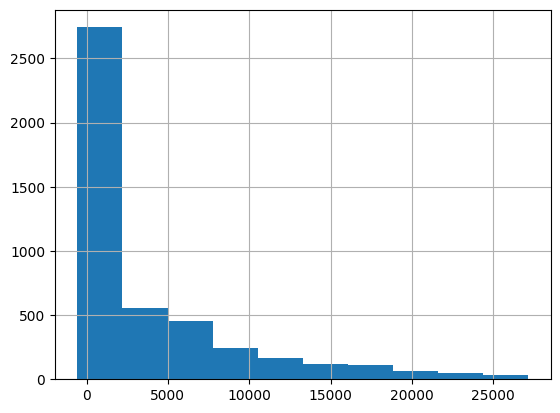

In [429]:
# plt.scatter(X_test_pred,y_test)
plt.hist(y_test)
plt.hist(X_test_pred)
plt.show()
DF.ts.hist()

C:\Users\TurnerJosh\AppData\Local\Temp\ipykernel_6584\922638292.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=date_from, right=date_to)


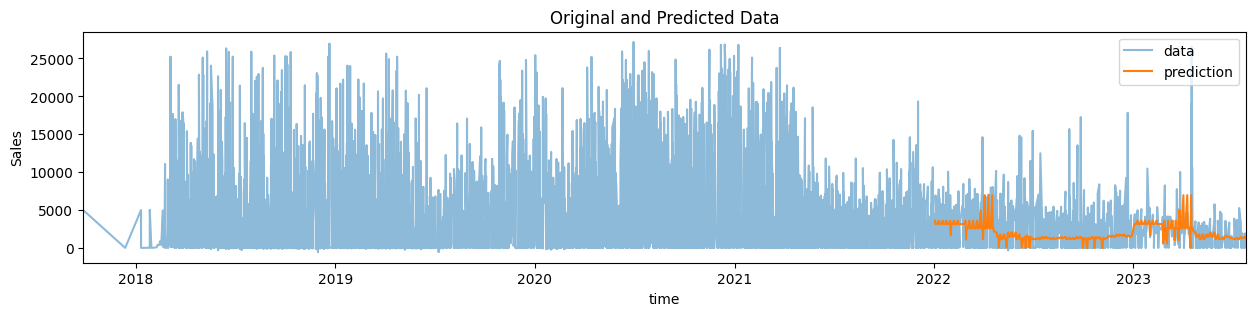

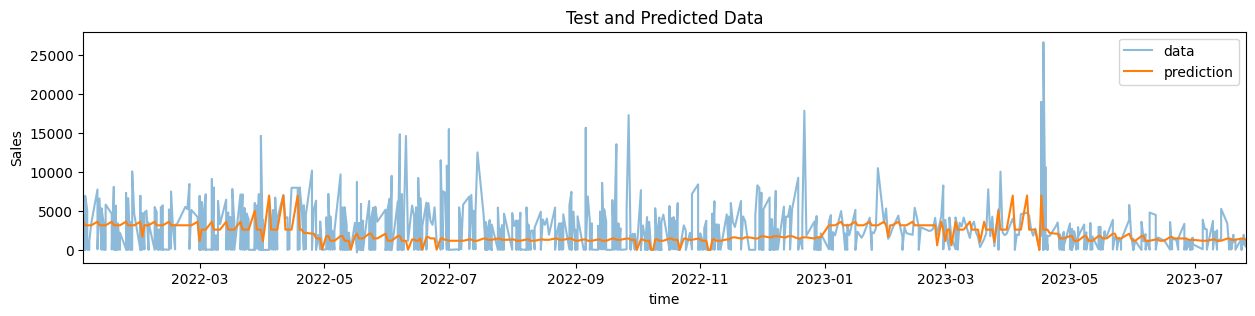

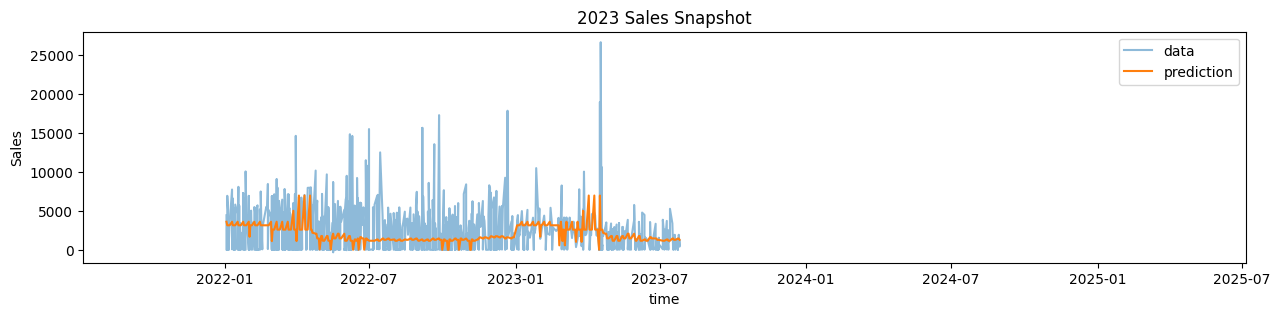

In [430]:

    
plot_performance(DF, DF.index[0].date(), DF.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

# Snapshot
plot_performance(y_test,y_test.index[-30].date(), y_test.index[-30].date(), '2023 Sales Snapshot')

plt.legend()

plt.show()

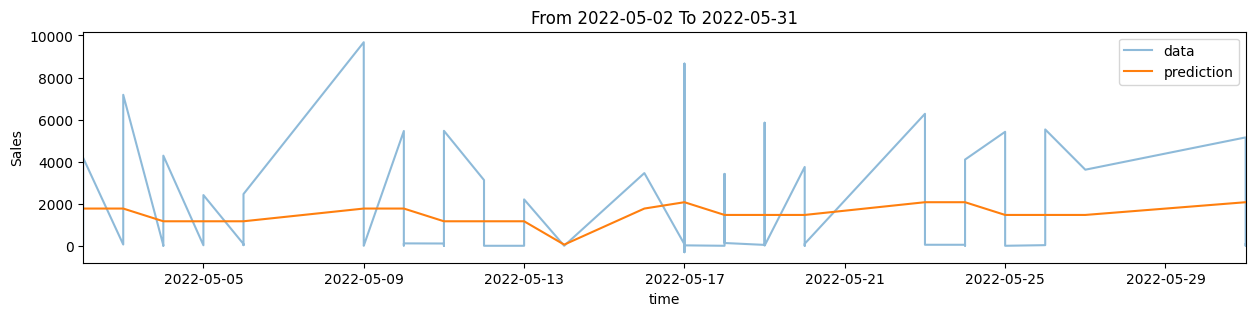

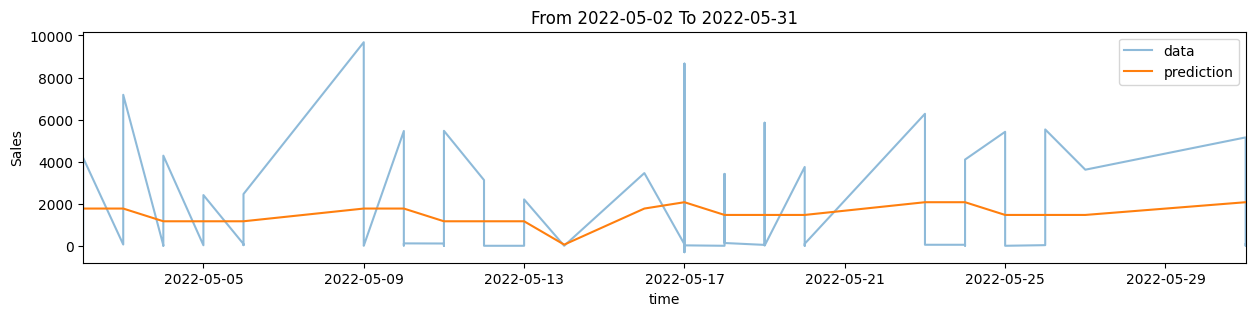

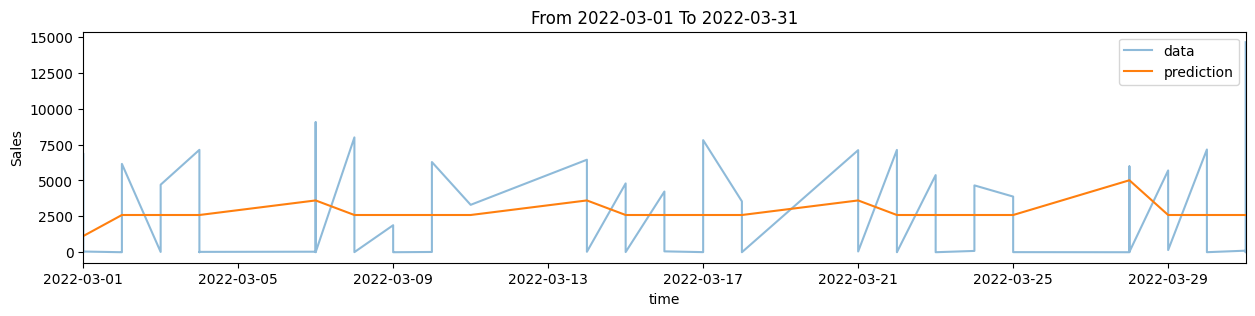

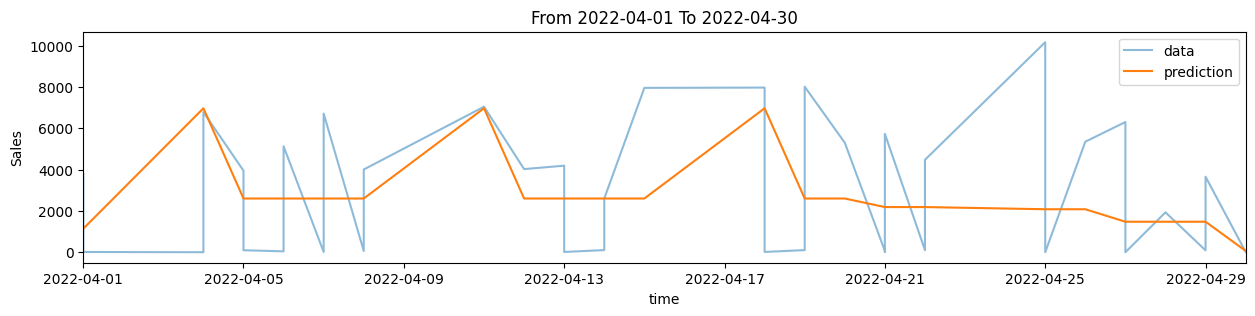

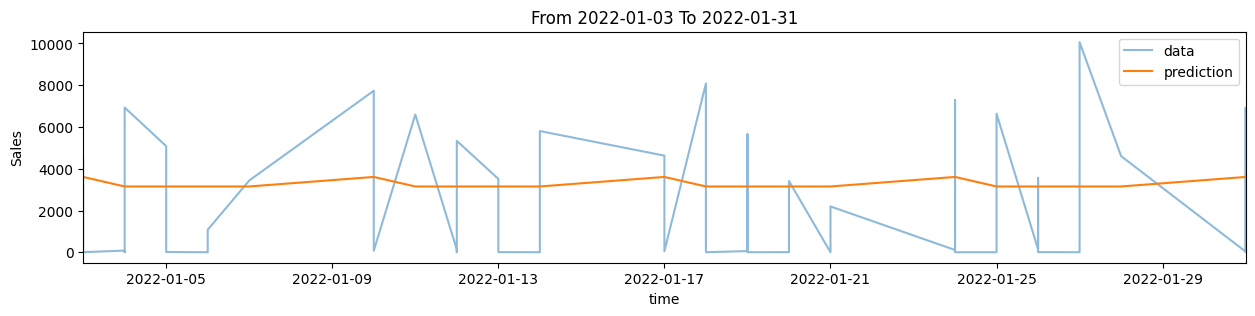

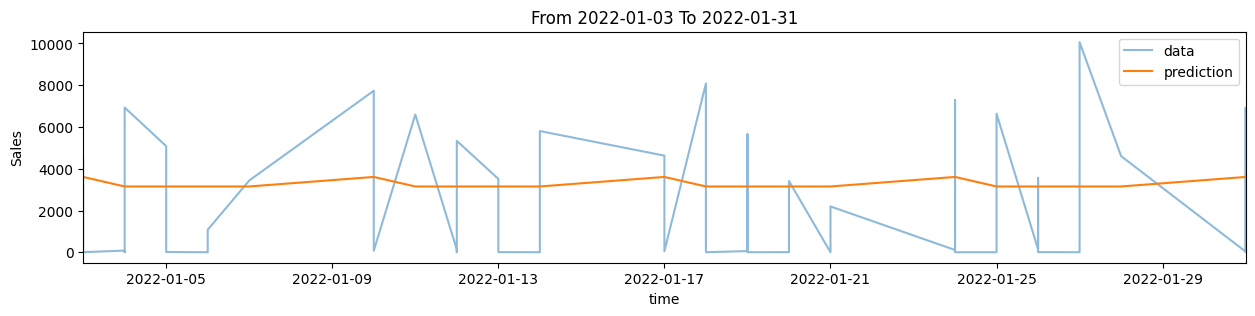

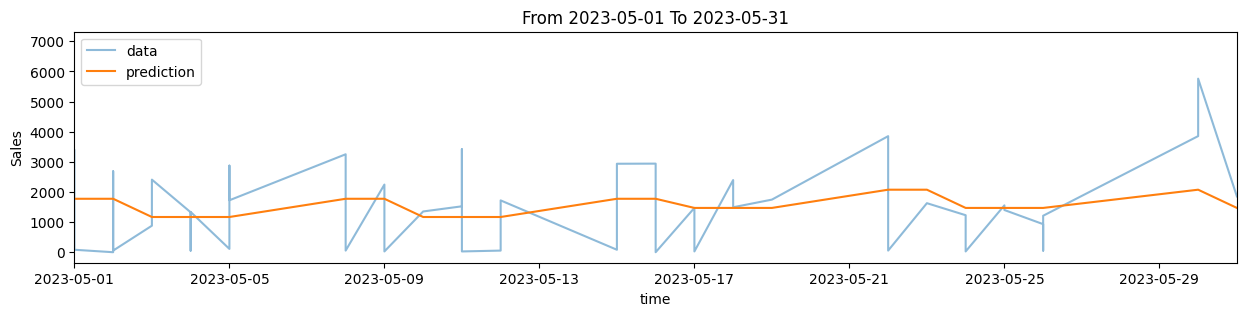

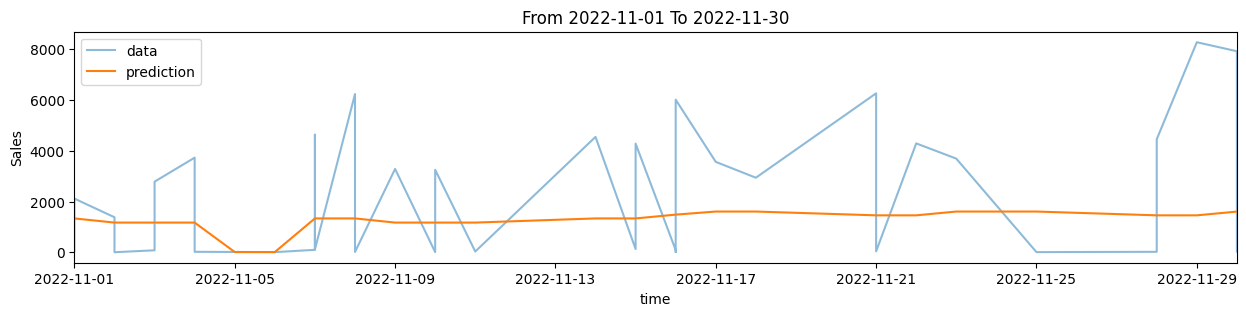

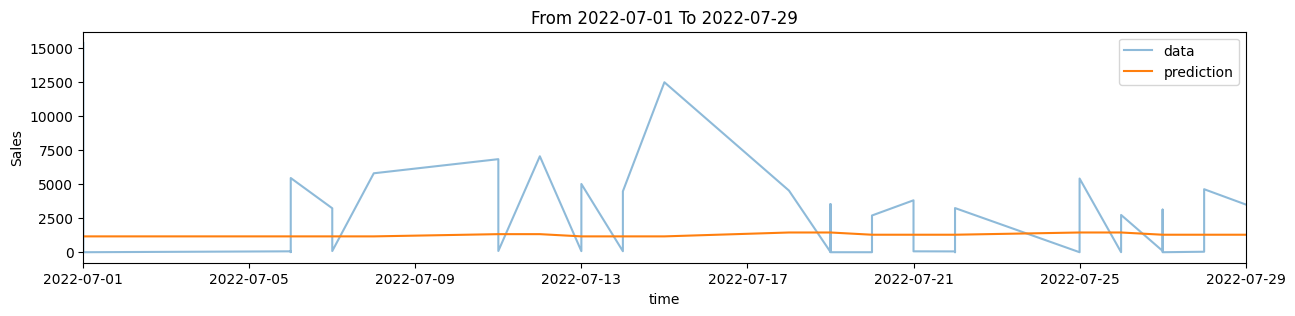

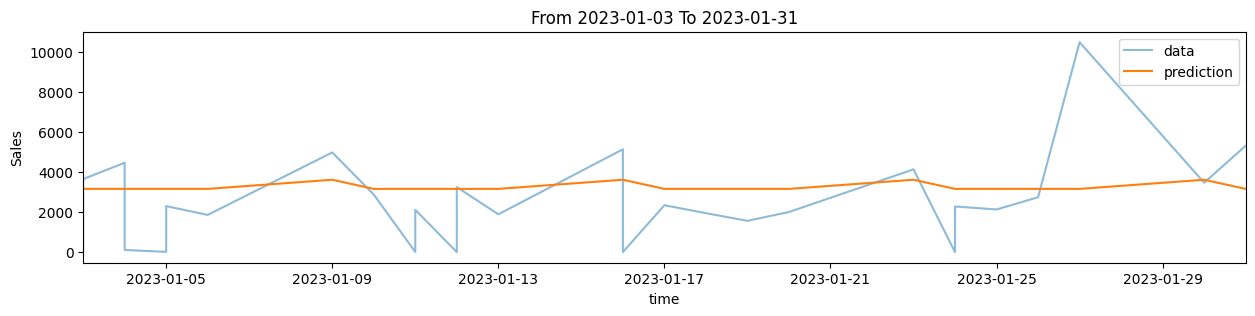

In [431]:
random_months = X_test[['year', 'month']].sample(10)
for month in random_months.iterrows():
    index = (X_test.year == month[1].year) & \
            (X_test.month == month[1].month)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())

In [205]:
# Inverse transform the predictions to put in terms of sales (no log)
# y_test = scaler.inverse_transform(y_test.values.reshape(-1,1))
# y_pred = scaler.inverse_transform(X_test_pred.reshape(-1,1))

In [ ]:
# y_test = np.expm1(y_test).values
# y_test = scaler.inverse_transform(y_test.reshape(-1,1))
# y_test.mean(),y_test.min(),y_test.max(),y_test.std()

In [404]:
# X_test_pred = np.expm1(X_test_pred)
# X_test_pred = scaler.inverse_transform(X_test_pred.reshape(-1,1))
# X_test_pred.mean(),X_test_pred.min(),X_test_pred.max(),X_test_pred.std()

In [432]:
np.sqrt(mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred))

3082.610107186891

In [433]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [434]:
mean_absolute_percentage_error(y_true=y_test,
                   y_pred=X_test_pred)

7942.229390857054

In [435]:
# Percent mean error for 10 random months
error_by_week = []
random_months = X_test[['year', 'month']].sample(10)
for month in random_months.iterrows():
    index = (X_test.year == month[1].year) & \
            (X_test.month == month[1].month)
    error_by_week.append(mean_absolute_percentage_error(y_test[index], X_test_pred[index]))
pd.Series(error_by_week, index=random_months.index)

ds
2023-01-24    17764.373373
2022-02-11    11610.502528
2022-10-11     7132.000866
2022-05-18     5668.017058
2022-01-18    17308.188637
2023-07-24     1010.504388
2022-03-24    12798.399587
2023-07-18     1010.504388
2022-08-05     6077.766210
2022-08-04     6077.766210
dtype: float64

In [436]:
X_test['Charge Amount'] = y_test.copy()
X_test['Charge Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['year','month','dayofmonth']) \
   .mean()[['Charge Amount','Charge Prediction','error','abs_error']]

C:\Users\TurnerJosh\AppData\Local\Temp\ipykernel_6584\2789129400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Charge Amount'] = y_test.copy()


In [437]:
error_by_day.sort_values('error', ascending=True).head(10)

Charge Amount  Charge Prediction        error  \
year month dayofmonth                                                  
2022 4     4             2261.333333        6968.410156 -4707.076823   
           18            2693.333333        6968.410156 -4275.076823   
     3     28            2004.000000        5013.589844 -3009.589844   
2023 4     3             4007.000000        6968.410156 -2961.410156   
2022 1     6              367.666667        3153.233154 -2785.566488   
2023 3     27            2600.500000        5013.589844 -2413.089844   
     2     8              832.000000        3153.233154 -2321.233154   
     3     20            1388.000000        3609.577637 -2221.577637   
     4     10            4773.000000        6968.410156 -2195.410156   
2022 3     9              487.750000        2595.998535 -2108.248535   

                         abs_error  
year month dayofmonth               
2022 4     4           4707.076823  
           18          4942.803385  
     3     28          3651.196615  
2023 4     3           2961.410156  
2022 1     6           2785.566488  
2023 3     27          2594.500000  
     2     8           2321.233154  
     3     20          2221.577637  
     4     10          2195.410156  
2022 3     9           2108.248535

In [384]:
# plot_series = DF[DF.index<pd.Timestamp(DF.index[1].date())]
# plot_acf(DF)
DF.index

DatetimeIndex(['2017-09-26', '2017-12-12', '2018-01-10', '2018-01-10',
               '2018-01-11', '2018-01-12', '2018-01-26', '2018-01-26',
               '2018-01-29', '2018-02-07',
               ...
               '2023-07-21', '2023-07-21', '2023-07-21', '2023-07-24',
               '2023-07-24', '2023-07-24', '2023-07-25', '2023-07-25',
               '2023-07-26', '2023-07-26'],
              dtype='datetime64[ns]', name='ds', length=4540, freq=None)

In [385]:
DF.mean()

ts    0.762834
dtype: float64

In [231]:
# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 90

X, y = [], []
for i in range(len(DF) - sequence_length):
    X.append(DF['ts'].iloc[i:i + sequence_length])
    y.append(DF['ts'].iloc[i:i + sequence_length].mean())

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y.shape

(4450,)

In [232]:
avgmodel_pred = y[-797:]

In [233]:
print("RMSE 3 month Avg:", np.sqrt(mean_squared_error(y_true=y_test,
                   y_pred=avgmodel_pred)))

RMSE 3 month Avg: 3037.5611134972337


In [108]:
X_test.shape,X_test_pred.shape

((797, 13), (797,))

In [102]:
DF.ts.iloc[-30:].index

DatetimeIndex(['2023-07-07', '2023-07-07', '2023-07-10', '2023-07-10',
               '2023-07-11', '2023-07-12', '2023-07-12', '2023-07-12',
               '2023-07-13', '2023-07-13', '2023-07-14', '2023-07-14',
               '2023-07-17', '2023-07-18', '2023-07-18', '2023-07-18',
               '2023-07-19', '2023-07-19', '2023-07-20', '2023-07-20',
               '2023-07-21', '2023-07-21', '2023-07-21', '2023-07-24',
               '2023-07-24', '2023-07-24', '2023-07-25', '2023-07-25',
               '2023-07-26', '2023-07-26'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [92]:
error_by_day

Charge Amount  Charge Prediction        error  \
year month dayofmonth                                                  
2022 1     3             2223.500000        4034.574707 -1811.074707   
           4             2340.666667        4034.574951 -1693.908040   
           5             2549.500000        4034.574707 -1485.074707   
           6              367.666667        4034.574951 -3666.908040   
           7             3439.000000        4034.574707  -595.574707   
...                              ...                ...          ...   
2023 7     20            1461.500000        1252.108887   209.391113   
           21             478.000000        1252.108887  -774.108887   
           24             752.333333        1366.043457  -613.710124   
           25            1316.500000        1366.043457   -49.543457   
           26             815.000000        1252.108887  -437.108887   

                         abs_error  
year month dayofmonth               
2022 1     3           2215.500000  
           4           3625.524902  
           5           2533.500000  
           6           3666.908040  
           7            595.574707  
...                            ...  
2023 7     20           473.500000  
           21           858.036296  
           24           667.014486  
           25           618.500000  
           26           437.108887  

[413 rows x 4 columns]